In [1]:
# import libraries

import matplotlib.pyplot as plt
import stk
import numpy as np
from pylab import *

import MDAnalysis as mda
import pywindow as pw

from scipy.ndimage import gaussian_filter1d
from scipy.spatial import ConvexHull

%matplotlib inline

c:\Users\domin\anaconda3\envs\stk1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Must update the cage used in the below code cell. Variable names of tritopic_bb, ditopic_bb and cage should be kept the same.

In [2]:
# must update stk cage building used here

tritopic_bb = stk.BuildingBlock('C1=C(C=C(C=C1C=O)C=O)C=O', [stk.AldehydeFactory()])
ditopic_bb = stk.BuildingBlock(smiles='N[C@@H]1CCCC[C@H]1N',functional_groups=[stk.PrimaryAminoFactory()],)
cage = stk.ConstructedMolecule(
            topology_graph=stk.cage.FourPlusSix(building_blocks={
                    ditopic_bb: range(4, 10),tritopic_bb: range(0, 4),},optimizer =stk.MCHammer(),),)

In [3]:
# load the system to MDanalysis universe. update parameters if needed.
u = mda.Universe("lammps_files/lammps_input_data.data", "lammps_files/lammps_output_lammpstrj.lammpstrj", format="LAMMPSDUMP", lammps_coordinate_convention="scaled", dt=1)
no_frames = len(u.trajectory)
sim_length = 10 # simulation length
time_data = (np.array(range(0, no_frames)) / ((no_frames-1)/sim_length)).tolist() # setup x axis list for plots

In [4]:
def get_cage_frame_data(file_name, frame_number):
    '''
    Outputs the position matrix of the cage for a given frame.

    Inputs:
    file_name (str): path to the cage only unwrapped file
    frame_number (int): the frame to be extracted
    Returns:
    frame_data (list): list[cage_atom][coorindates] containing cage position information
    '''
    # open file and setup counts and conditions
    datafile = open(file_name, 'r')
    line_count = 0
    frame_count = 0 # count of lines after frame has been identified
    frame_id = False
    frame_data = [] # empty list to store cage frame information

    # loop through each line
    for line in datafile:

        # define number of atoms in cage on first line of file
        if line_count == 0:
            frame_atoms_range = range(0,int(line))
        line_count = line_count + 1

        # when condition is true, extract frame coordinates
        if frame_id == True:
            if frame_count in frame_atoms_range:
                line = line.split()
                frame_data.extend([[float(x) for x in line[1:]]])
            frame_count = frame_count + 1
        
        # set condition to true when the desired frame is encountered
        if line == f"frame {frame_number}\n":
            frame_id = True
    return frame_data

For the code cell below, the mol.calculate_windows lines can be commented out to significantly speed up the code.

In [5]:
# code to output pywindow pore analysis for each frame

# setup lists to store parameter information
pore_volume = []
pore_diameter = []
pore_windows = []
pore_windows_stdevs = []

# loop through each frame and update cage positions
for i in range(0,no_frames):
    cage = cage.with_position_matrix(np.array(get_cage_frame_data('data_storage/data_cage_only_unwrapped.xyz',i)))

    #transfer from stk to pywindow for analysis
    rd = cage.to_rdkit_mol()
    molsys = pw.MolecularSystem.load_rdkit_mol(rd)
    mol = molsys.system_to_molecule()
    pore_volume.extend([mol.calculate_pore_volume()])
    pore_diameter.extend([mol.calculate_pore_diameter()])

    # pywindow calculation of windows can returns errors, so setup try except block.
    try:
        frame_windows = mol.calculate_windows()
        windows_stdev = np.std(frame_windows)
        # only accept a successful windows calculation if standard deviation < 50 (pywindow can output extreme window sizes with large standard devitions without returning an error)
        if windows_stdev < 50:
            pore_windows.extend([len(frame_windows)])
            pore_windows_stdevs.extend([windows_stdev])
        else:
            pore_windows.extend([NaN])
            pore_windows_stdevs.extend([NaN])
    except:
        pore_windows.extend([NaN])
        pore_windows_stdevs.extend([NaN])

# change any negative pywindow volumes to zero to avoid negative volumes and possible plotting issues
for i in range(len(pore_volume)):
               if pore_volume[i] < 0:
                       pore_volume[i] = 0

print('Pore volumes:',pore_volume,'\nPore diameters:',pore_diameter,'\nNumber of pore windows',pore_windows,'\nPore window size standard deviations',pore_windows_stdevs)

Pore volumes: [189.33066339922854, 92.78106808162427, 87.3631485219507, 96.04860063457781, 85.04144297122365, 98.33512293016734, 100.86475947329068, 100.14137305601328, 61.77832392151461, 88.0481259760032, 42.53162123870476, 78.91841413357109, 78.68174915252445, 91.53525977514617, 80.80466440749174, 77.33676197596209, 61.34874165162114, 77.12831998083963, 100.34639912735187, 60.91917285308053, 86.04641179627896, 66.49326720804952, 68.85616614510388, 69.3524208031391, 75.08111965183461, 118.21256534611784, 60.80917360296048, 61.684726473157006, 68.77663468433218, 107.21334288882208, 76.7371469109098, 71.96559085600757, 58.92095346861175, 46.94306037222747, 79.4771576567031, 74.27097687486166, 94.50251543724542, 69.71212244089044, 53.58856123797049, 56.23807236475809, 85.36595304717251, 63.47408518395966, 85.46810295425082, 82.88496562385389, 84.91640958192686, 92.04464734549937, 59.60383783655234, 71.23133076198465, 73.28461420995225, 69.57445491581441, 84.45866686773411, 99.29281718603

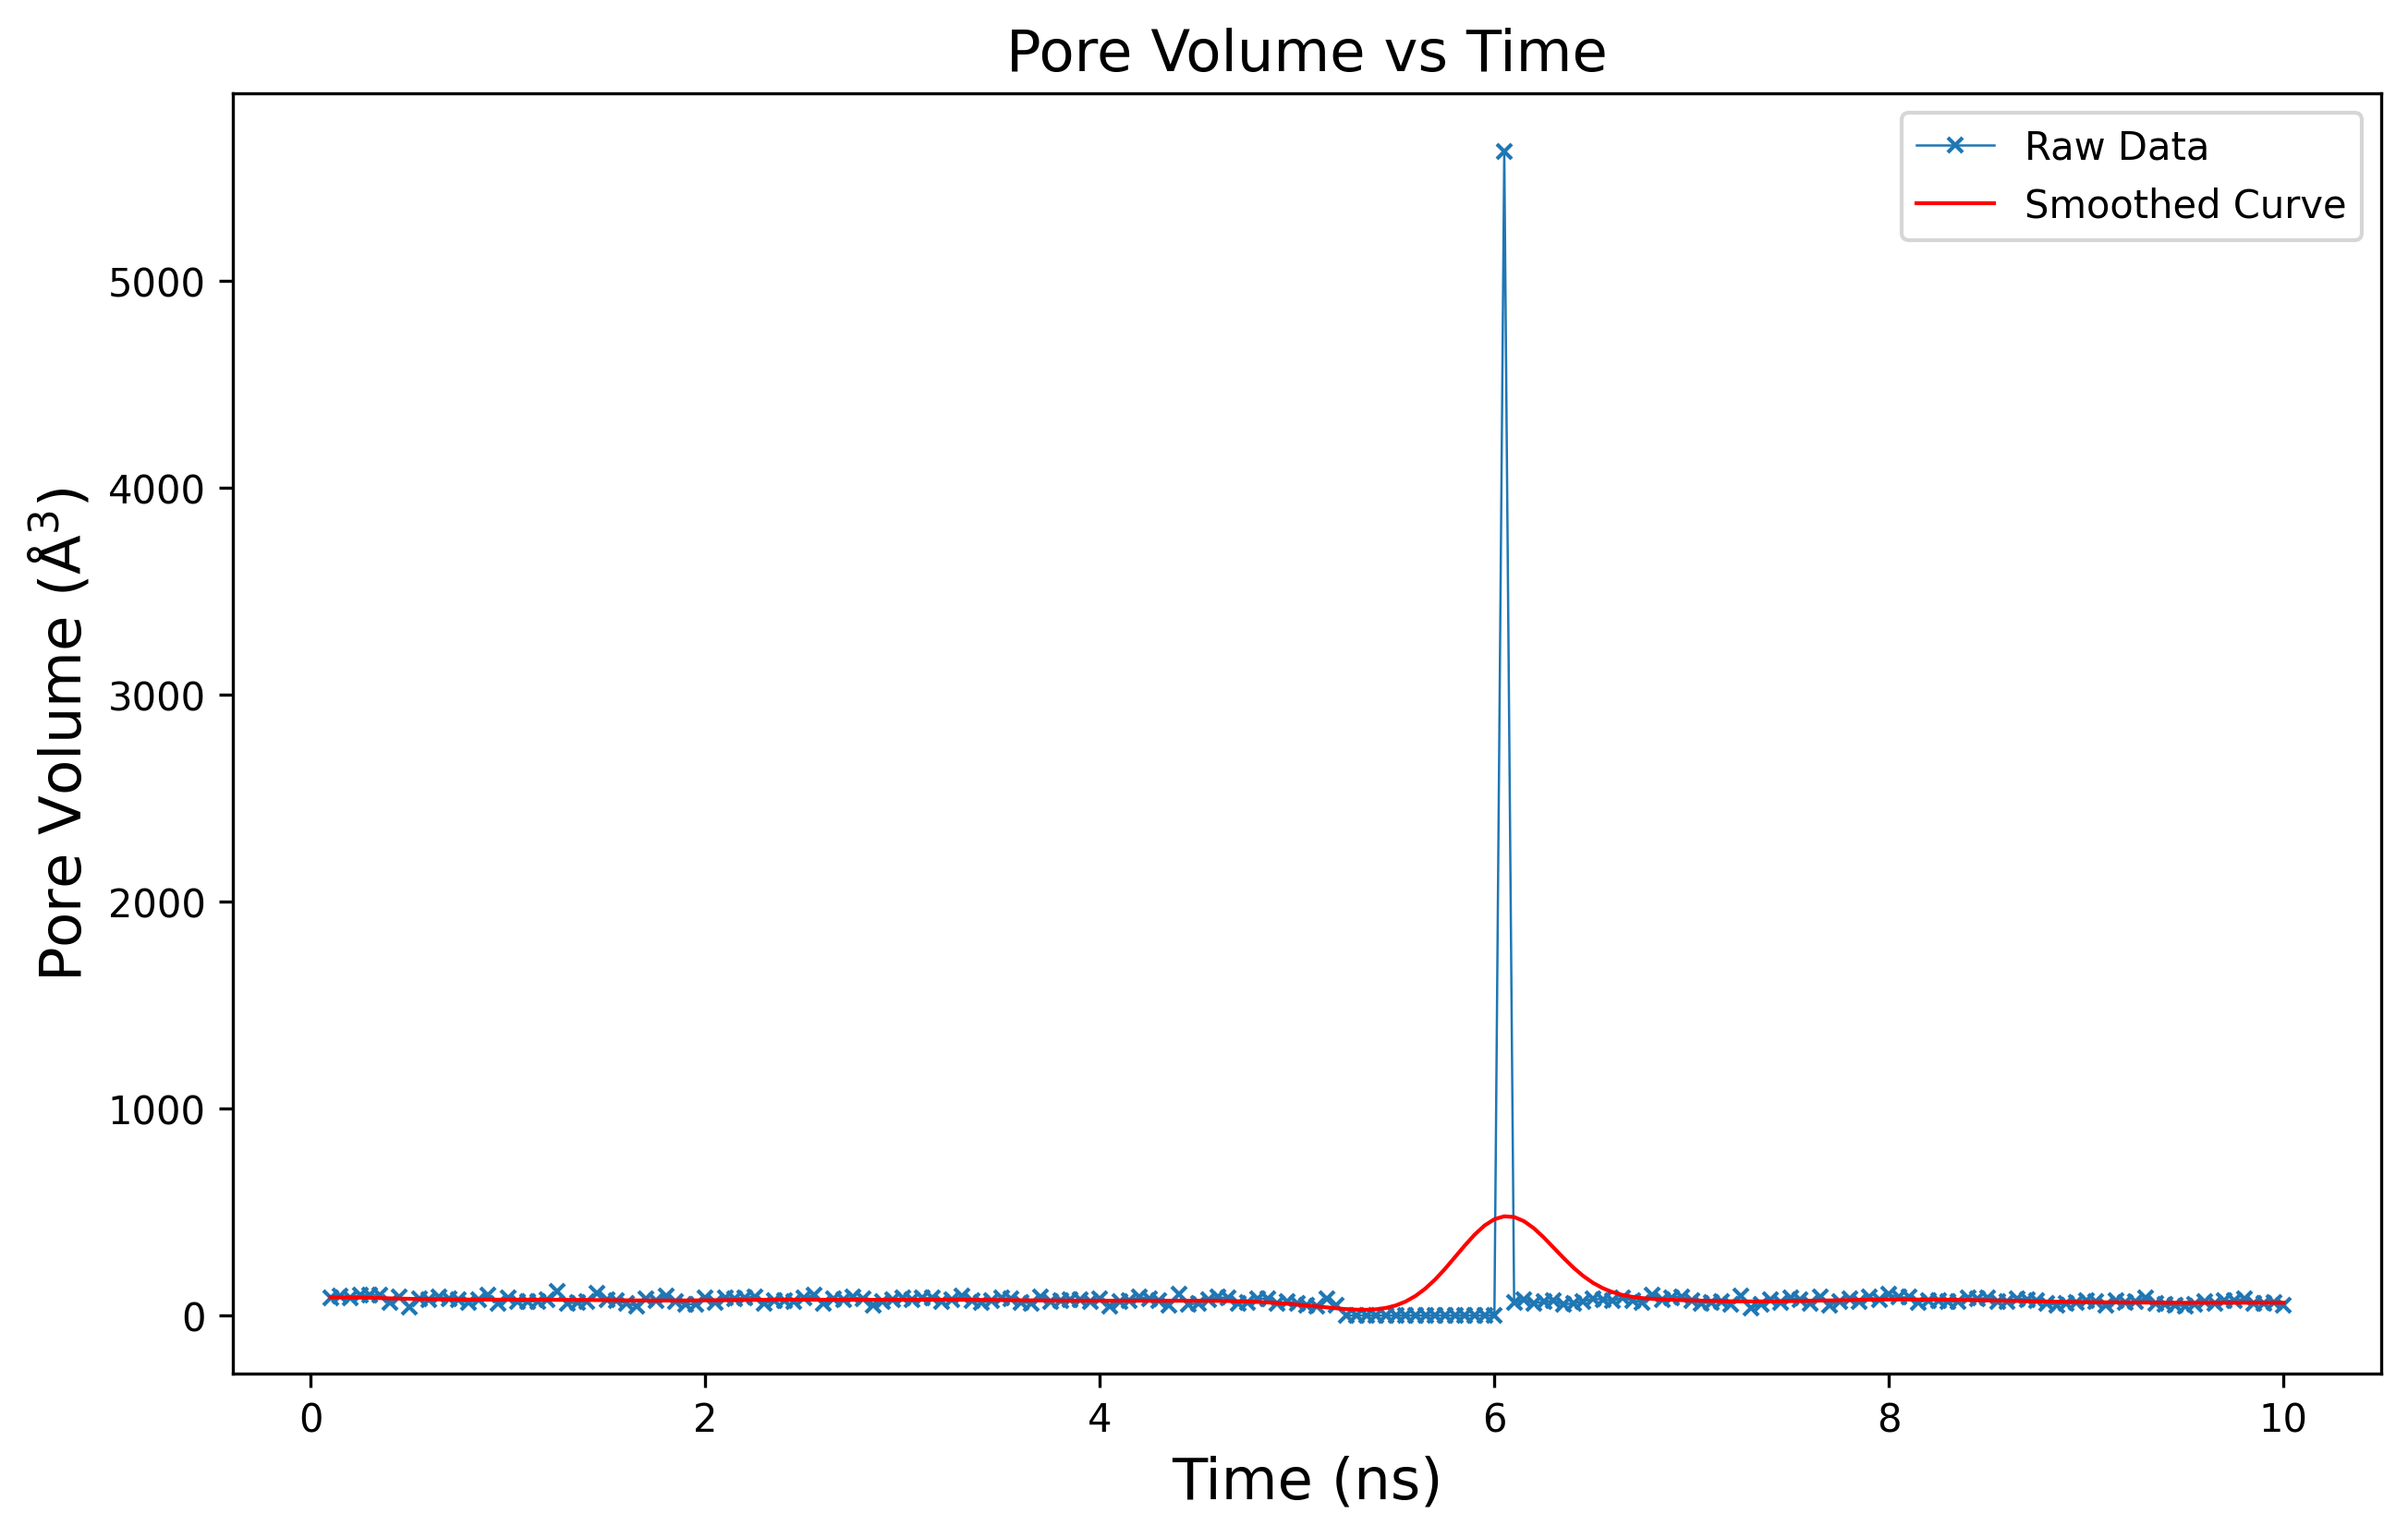

In [6]:
plt.figure(figsize=[10,6], dpi=300)
pore_volume_smooth = gaussian_filter1d(pore_volume[2:], sigma=5)  # increase sigma for more smoothing
plt.plot(time_data[2:], pore_volume[2:], marker='x', markersize=4, linewidth=0.6, label='Raw Data') # plot raw data
plt.plot(time_data[2:], pore_volume_smooth, linewidth=1, color='red', label='Smoothed Curve') # plot gaussian smoothed curve
plt.title('Pore Volume vs Time', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel(r'Pore Volume (Å$^{3}$)',fontsize=15)
plt.legend()
plt.show()

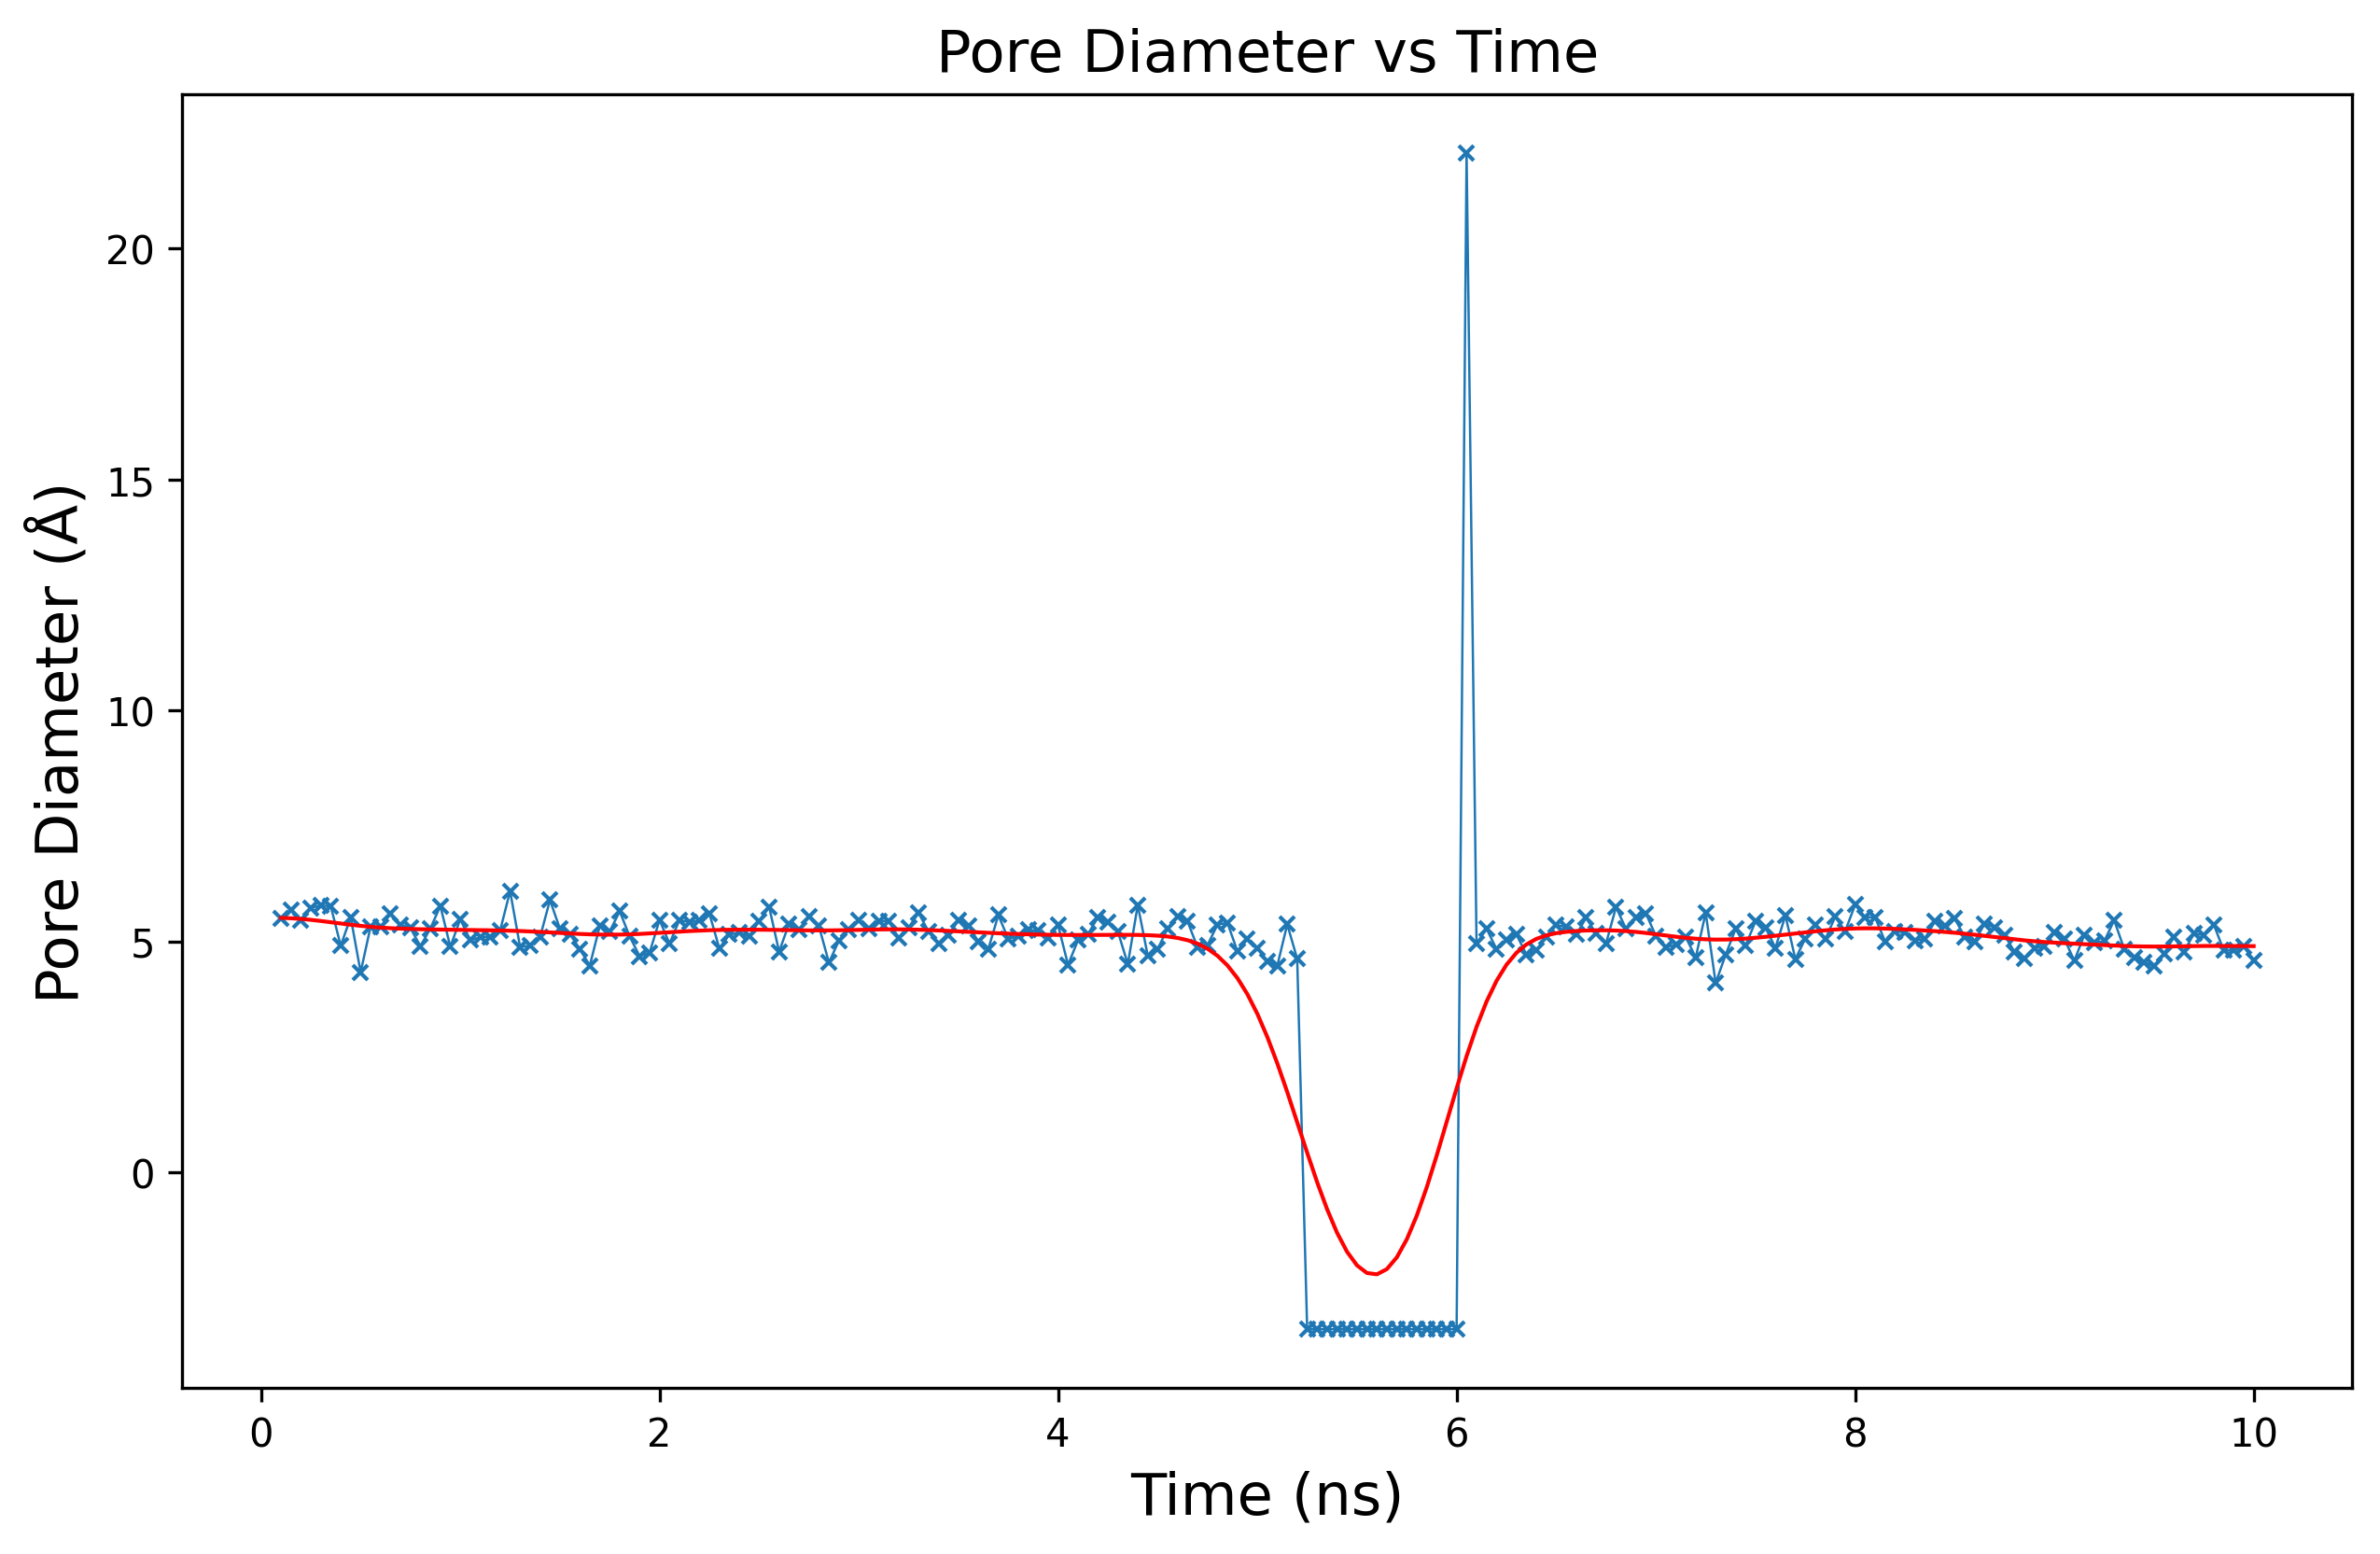

In [7]:
plt.figure(figsize=[10,6], dpi=300)
pore_diameter_smooth = gaussian_filter1d(pore_diameter[2:], sigma=5)  # increase sigma for more smoothing
plt.plot(time_data[2:], pore_diameter[2:], marker='x', markersize=4, linewidth=0.6, label='Raw Data') # plot raw data
plt.plot(time_data[2:], pore_diameter_smooth, linewidth=1, color='red', label='Smoothed Curve') # plot gaussian smoothed curve
plt.title('Pore Diameter vs Time', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel('Pore Diameter (Å)', fontsize=15)
plt.show()

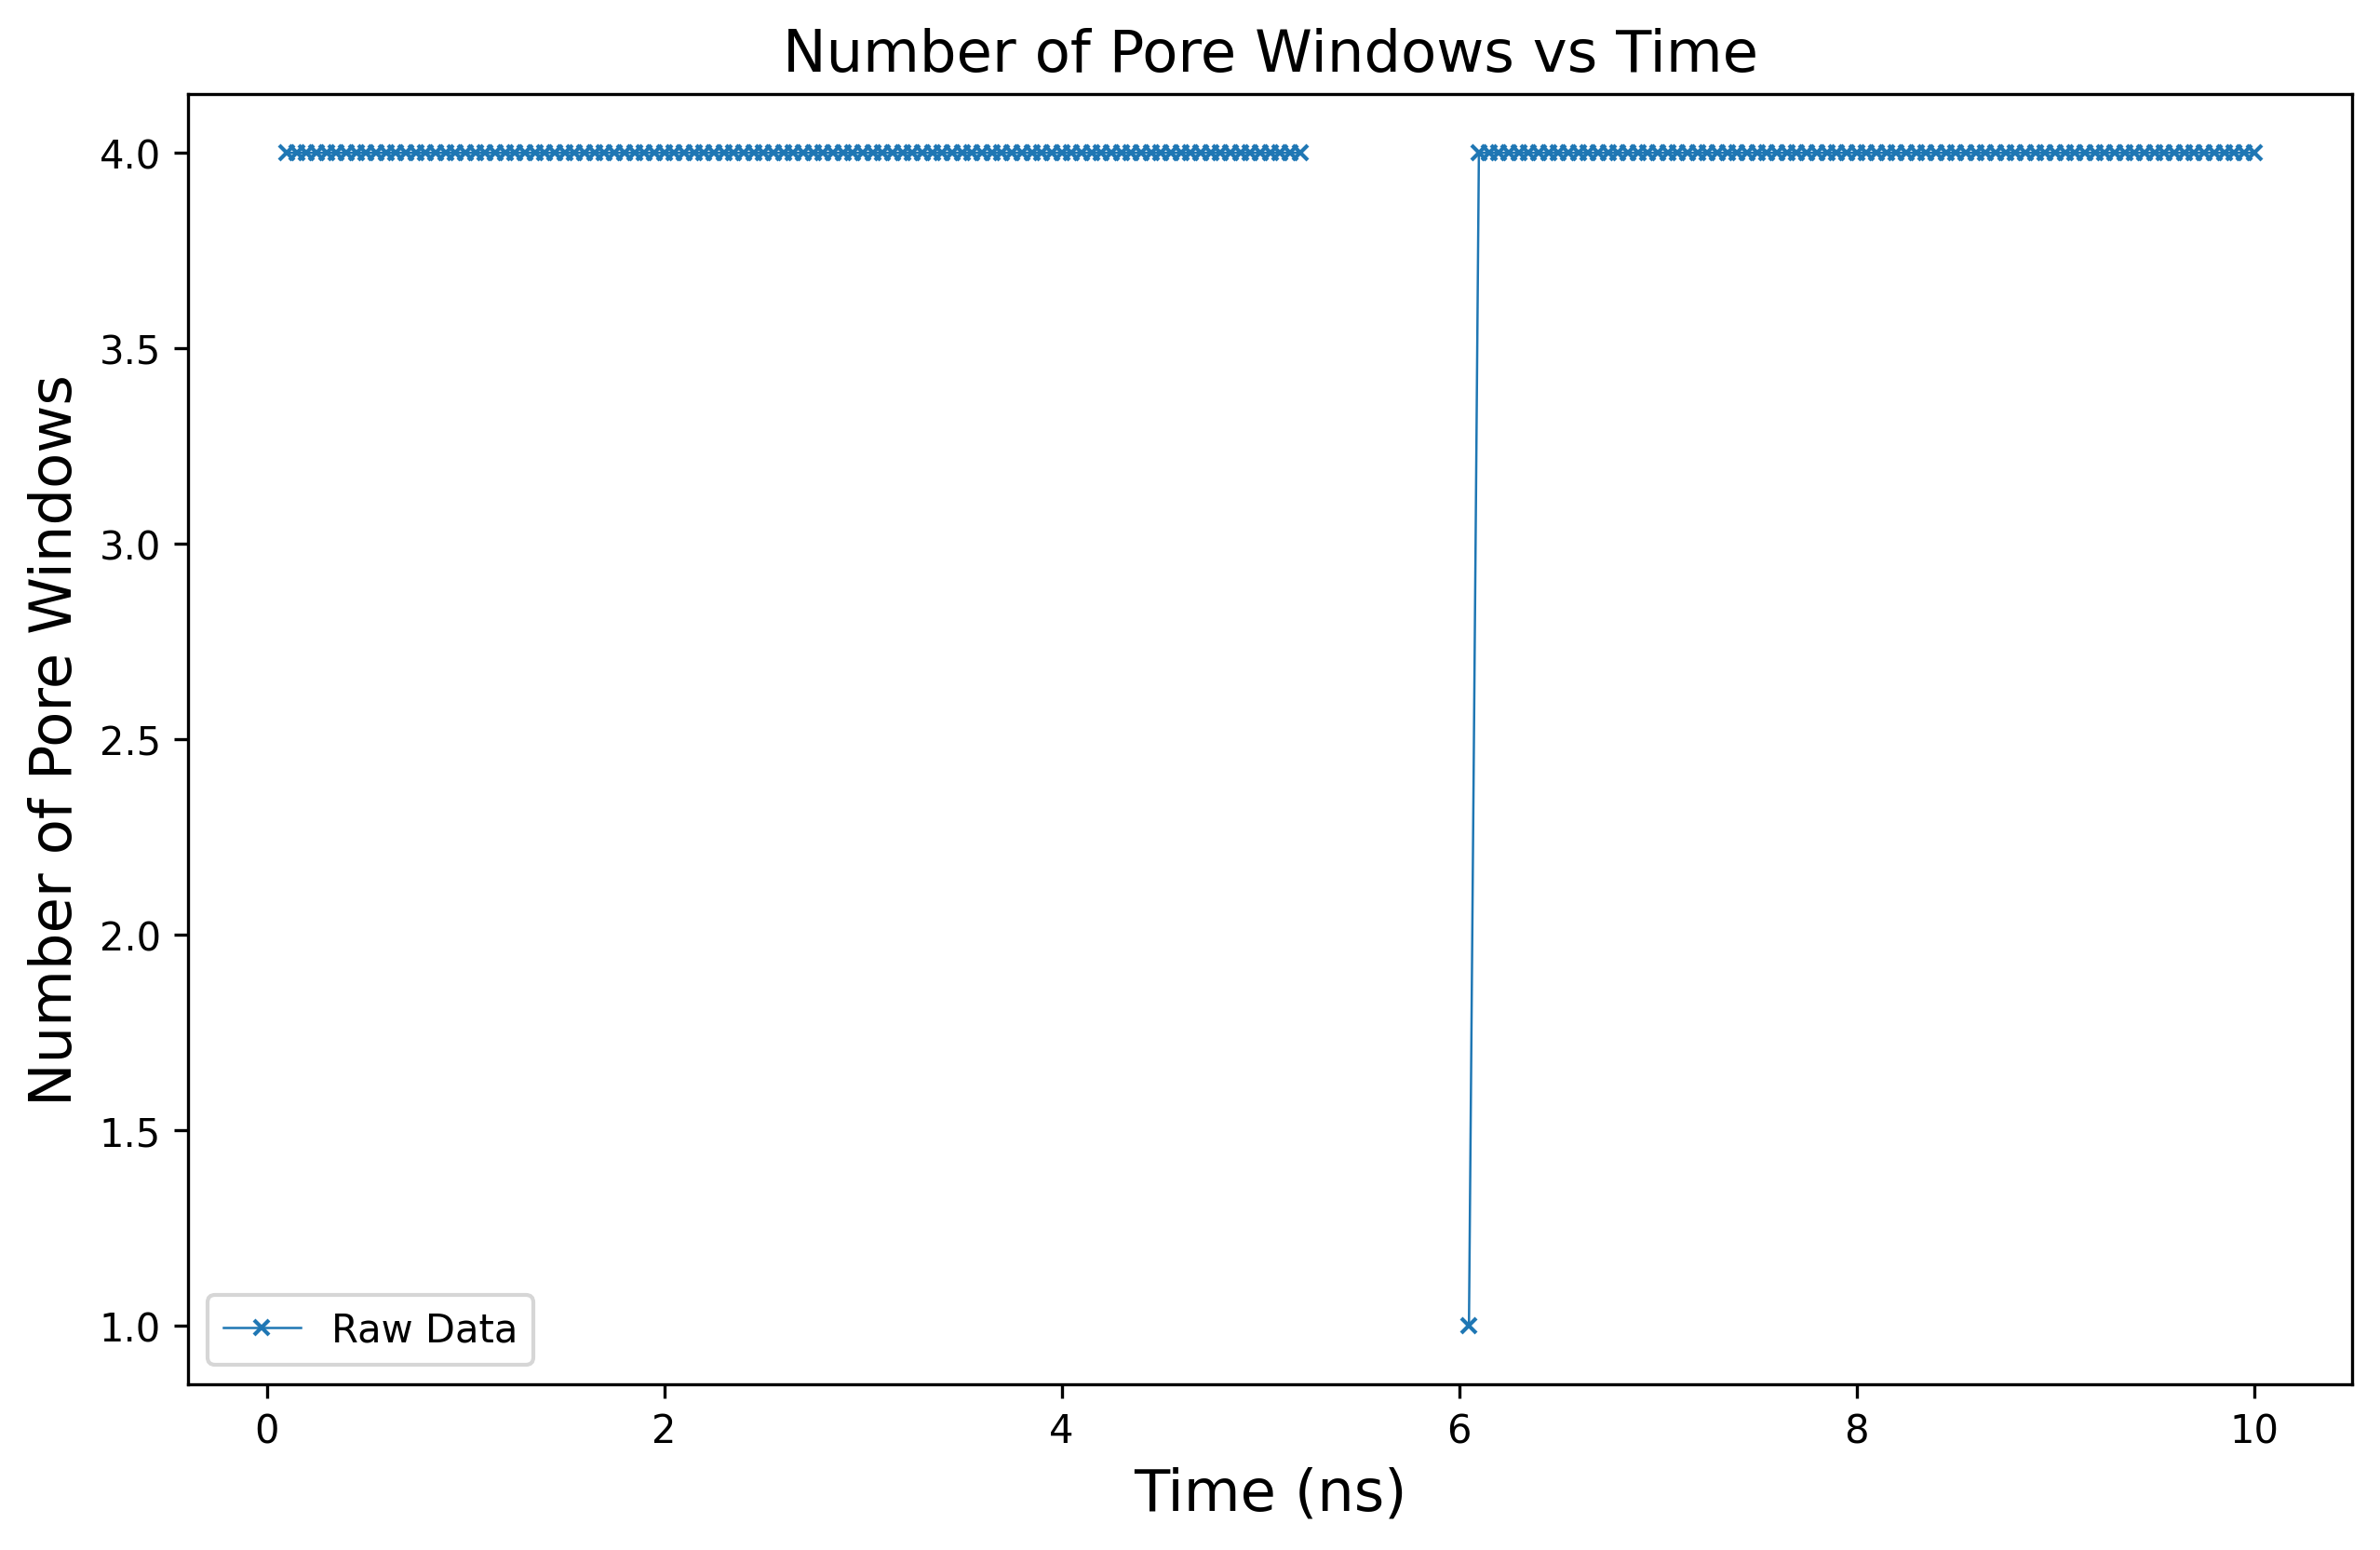

In [8]:
# can't plot smoothed curve due to presence of nan values
plt.figure(figsize=[10,6], dpi=300)
plt.plot(time_data[2:], pore_windows[2:], marker='x', markersize=4, linewidth=0.6, label='Raw Data') # plot raw data
plt.title('Number of Pore Windows vs Time', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel('Number of Pore Windows', fontsize=15)
plt.legend()
plt.show()

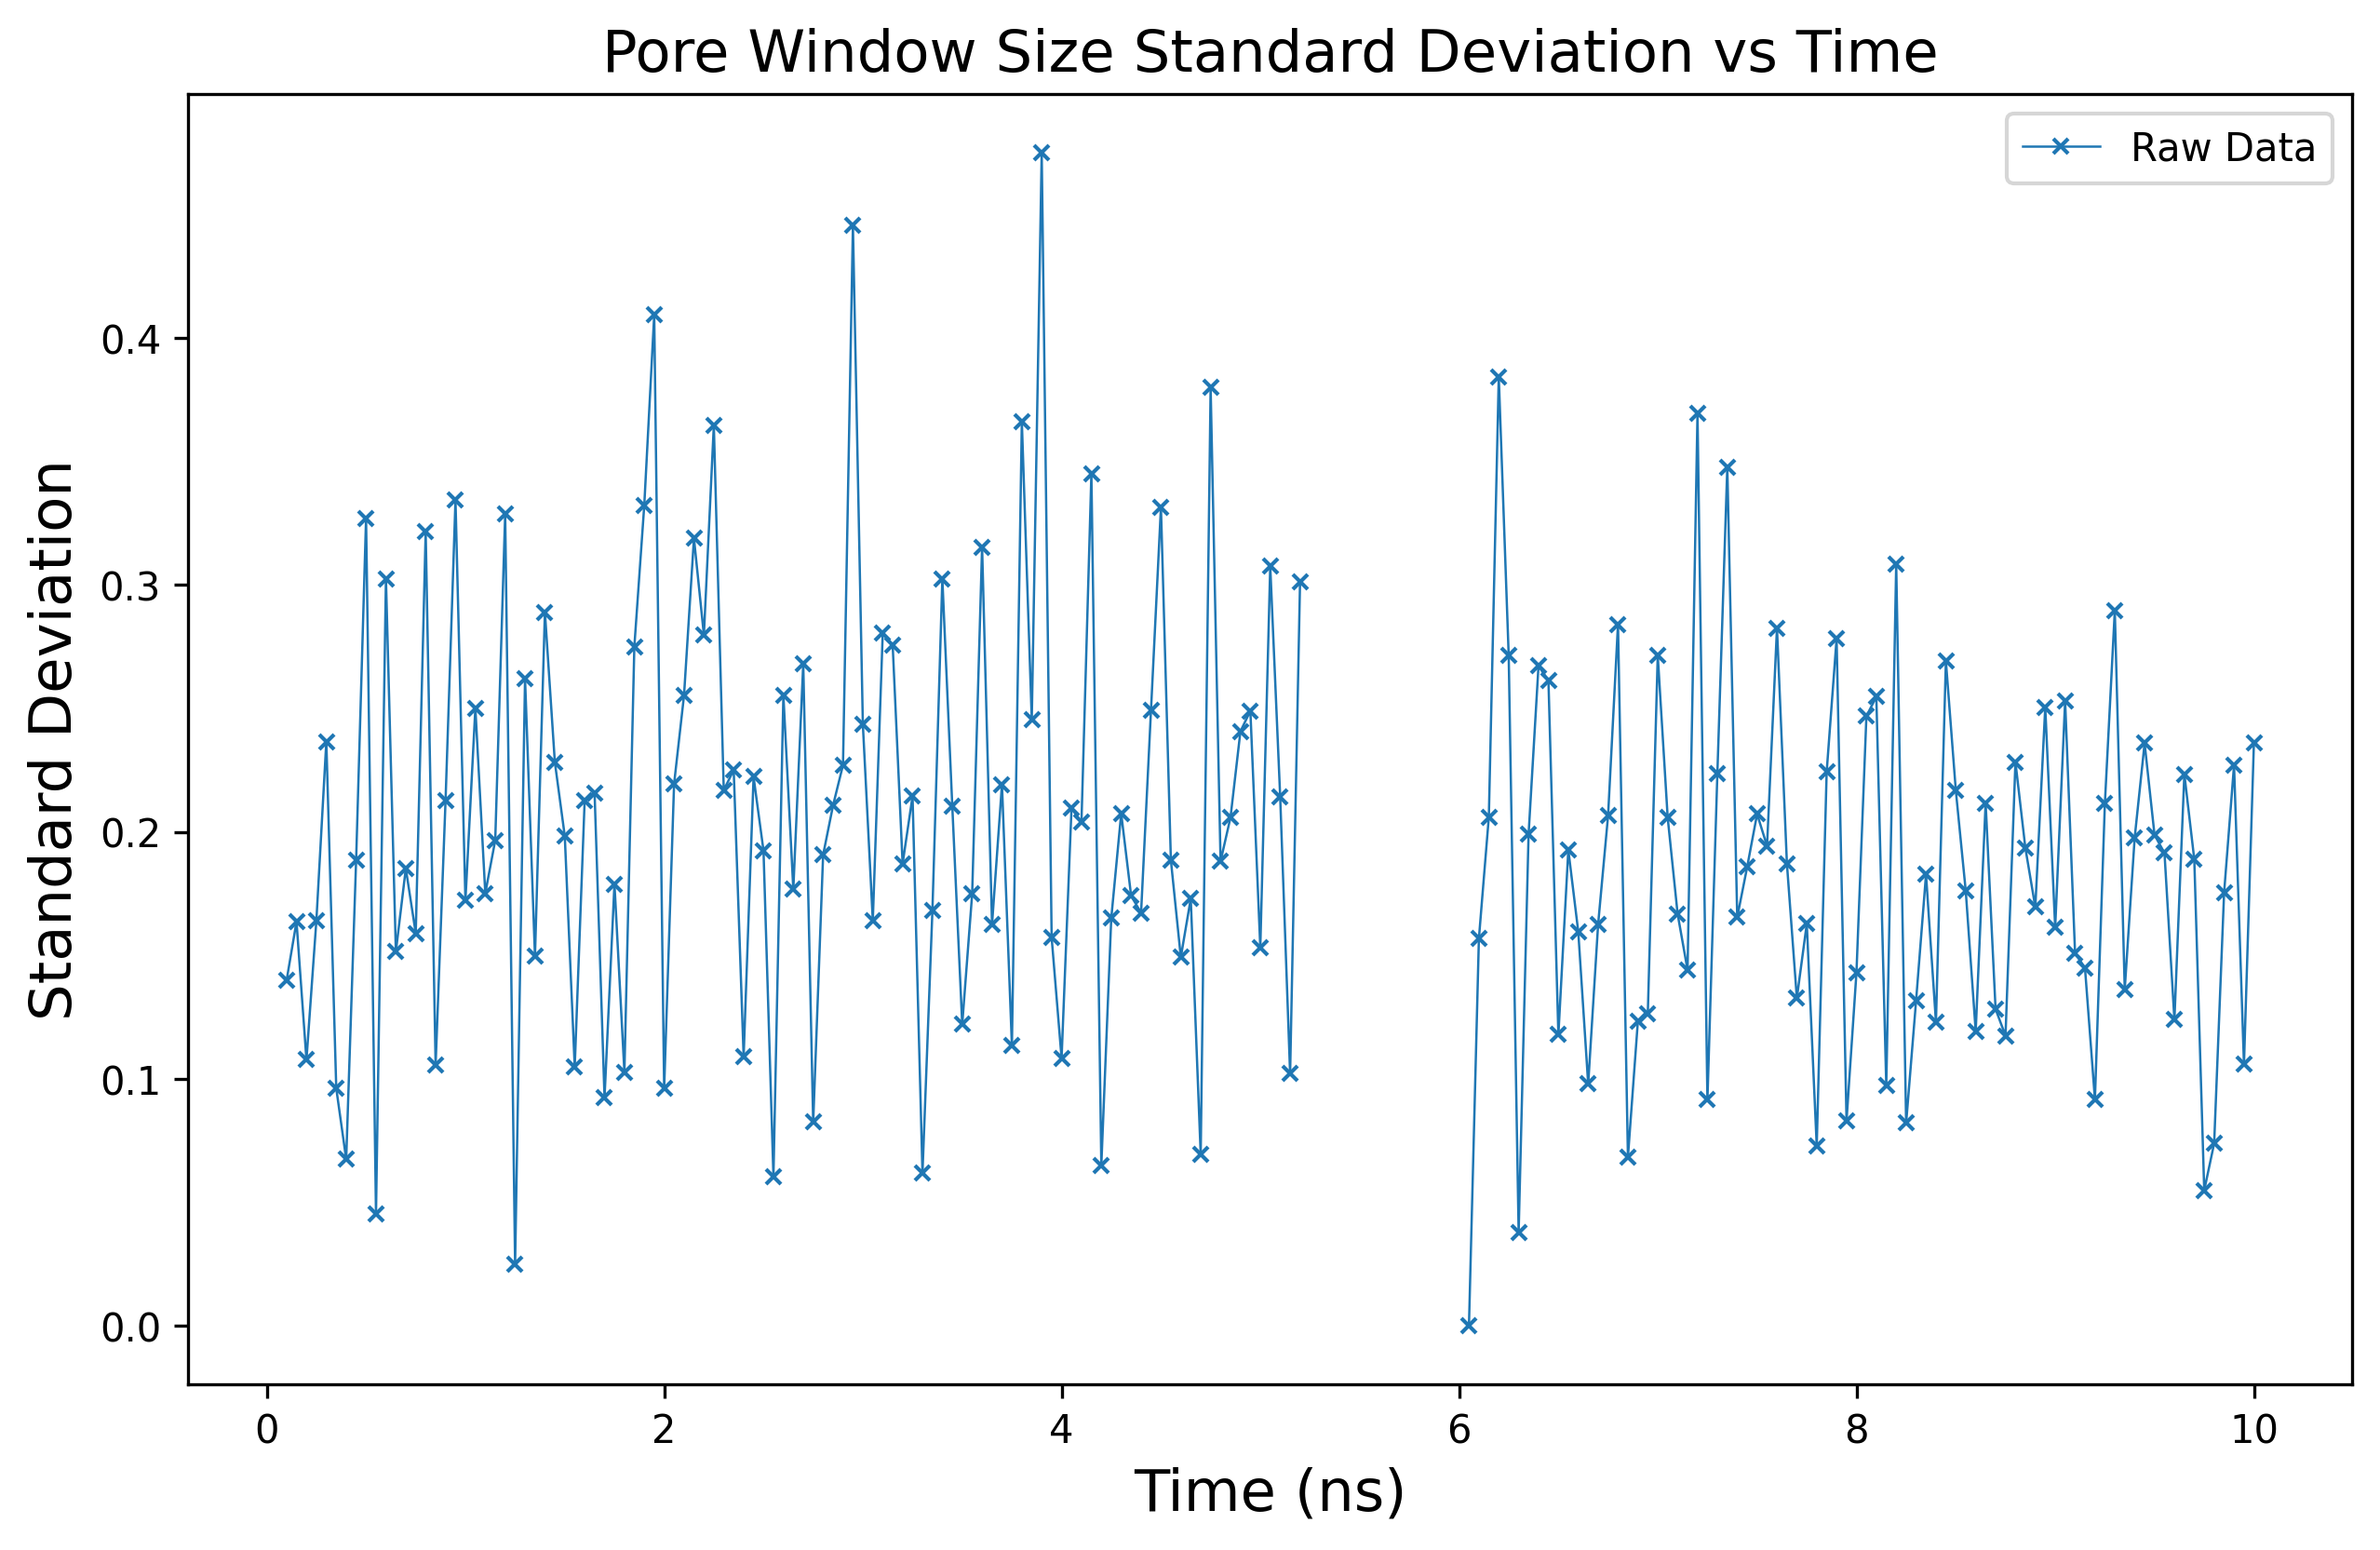

In [9]:
# can't plot smoothed curve due to presence of nan values
plt.figure(figsize=[10,6], dpi=300)
plt.plot(time_data[2:], pore_windows_stdevs[2:], marker='x', markersize=4, linewidth=0.6, label='Raw Data') # plot raw data
plt.title('Pore Window Size Standard Deviation vs Time', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel('Standard Deviation',fontsize=15)
plt.legend()
plt.show()

In [10]:
def get_reduced_building_block(building_block): 
    '''
    Takes an stk building block and removes deleter atoms, such that later updating of building block 
    position matrix can be done easily on a building block by building block basis.
    
    Inputs:
    building_block: stk building block
    Returns:
    reduced_building_block: stk building block with deleter atoms removed
    '''

    # identify stk ids of deleter atoms by looping through building block functional groups
    deleter_atom_ids = []
    for i in building_block.get_functional_groups():
        deleter_atom_ids.extend(list(i.get_deleter_ids()))

    # create stk atom list containing only non-deleter atoms
    filtered_atoms = [atom for atom in building_block.get_atoms() if atom.get_id() not in deleter_atom_ids]

    # we now need to correct the stk mapping for the filtered atoms
    # make dictionary to hold old_stk_id:new_stk_id mapping
    old_to_new_id = {old_id: new_id for new_id, old_id in enumerate(atom.get_id() for atom in filtered_atoms)}
    # use dictionary to create list containing only non-deleter atoms with fixed stk atom ids
    renumbered_atoms = [atom.with_id(new_id) for atom, new_id in zip(filtered_atoms, old_to_new_id.values())]


    # we now need to correct the stk bonding for the filtered atoms, with only bonds between non-deleted atoms
    # loop through original building block bonds and add non-deleted bonds to new bonding list, with fixed ids
    filtered_bonds = []
    for bond in building_block.get_bonds():
        if bond.get_atom1().get_id() in old_to_new_id and bond.get_atom2().get_id() in old_to_new_id:
            new_bond = stk.Bond(
                atom1=renumbered_atoms[old_to_new_id[bond.get_atom1().get_id()]],  # update atom1 id
                atom2=renumbered_atoms[old_to_new_id[bond.get_atom2().get_id()]],  # update atom2 id
                order=bond.get_order()  # keep the bond order the same
            )
            filtered_bonds.append(new_bond)

    # fix the position matrix to include only the non-deleted atoms 
    original_position_matrix = building_block.get_position_matrix()
    updated_position_matrix = np.array([original_position_matrix[old_id] for old_id in old_to_new_id])

    # construct the new building block with updated atoms, atom ids, bonds, and positions
    reduced_building_block = stk.BuildingBlock.init(
        atoms = renumbered_atoms,
        bonds = filtered_bonds,
        position_matrix = updated_position_matrix)
    
    print("Deleted Atom IDs:", deleter_atom_ids)
    print("Original Atom Count:", len(list(building_block.get_atoms())))
    print("Filtered Atom Count:", len(list(reduced_building_block.get_atoms())))
    print("Original Bond Count:", len(list(building_block.get_bonds())))
    print("Filtered Bond Count:", len(list(reduced_building_block.get_bonds())))
    print("New Atom ID Mapping:", old_to_new_id)

    return reduced_building_block

If using more than 2 types of building blocks, the below code will need to be adapted. The order of list appending in defining building_blocks below also needs to be in the same order as defined when first constructing the cage above. Here it is based on tritopic building block followed by ditopic building blocks; eg: during cage building, building blocks: {ditopic_bb: range(8, 20),tritopic_bb: range(0, 8)}.

In [11]:
# define parameters
no_tritopic_bb = cage.get_num_building_block(tritopic_bb)
no_ditopic_bb = cage.get_num_building_block(ditopic_bb)
no_building_blocks = no_ditopic_bb + no_tritopic_bb
cage_file_name = 'data_storage/data_cage_only_unwrapped.xyz'

building_blocks = [get_reduced_building_block(tritopic_bb) for _ in range(no_tritopic_bb)] + [get_reduced_building_block(ditopic_bb) for _ in range(no_ditopic_bb)]

Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Dele

In [12]:
# code to store tritopic building block centres of masses (com) for each frame as a list of 
# shape [no_tritopic_bbs][no_frames][coordinates]
# also outputs an .xyz file of the coms for easy visualisation. Each building block is represented as an H atom 
# at its com

tritopic_bb_com_data = [[] for _ in range(no_tritopic_bb)] # setup list for each tritopic building block

with open('data_storage/coms_tritopic_bbs.xyz', 'w') as f:
    for frame_number in range(0,no_frames): # loop through each frame
        f.write(f"{no_tritopic_bb}\n") # write number of tritopic building blocks
        f.write(f"frame {frame_number}\n") # write frame number

        cage_frame_data = np.array(get_cage_frame_data(cage_file_name,frame_number)) # obtain cage position matrix for specified frame

        # loop through each tritopic building block, extract relevant atomic coordinates and calculate com
        for bb_number in range(0,no_tritopic_bb):
            no_atoms_in_bb = building_blocks[bb_number].get_num_atoms() # define number of atoms in building block
            upper_index = (bb_number+1)*no_atoms_in_bb # define region in which building block data resides within cage_frame_data        
            bb_frame_data = cage_frame_data[upper_index - no_atoms_in_bb:upper_index] # get building block position matrix

            # update building block position matrix and calculate com
            building_blocks[bb_number] = building_blocks[bb_number].with_position_matrix(bb_frame_data)
            rdkit_mol = building_blocks[bb_number].to_rdkit_mol()
            molsys = pw.MolecularSystem.load_rdkit_mol(rdkit_mol)
            mol = molsys.system_to_molecule()
            com = mol.calculate_centre_of_mass()
            tritopic_bb_com_data[bb_number].extend([com])

            f.write(f"H {com[0]:.3f} {com[1]:.3f} {com[2]:.3f}\n")


In [13]:
def convex_hull_volume(bb_com_data, no_frames):
    '''
    Outputs convex hull volume data of 3D shape defined by the centres of masses of input building blocks.
    
    Inputs:
    bb_com_data (list): list[no_bbs][no_frames][coorindates] containing the building block centre of mass data
    no_frames (int): number of frames in the simulation
    Returns:
    frame_volumes (list): list of the convex hull volumes for each frame
    '''
    frame_volumes = []  # setup list to store volume for each frame
    
    # loop through each frame, obtain centre of mass data, calculate convex hull and get volume
    for frame_number in range(no_frames):
        com_positions = np.array([bb_com_data[bb][frame_number] for bb in range(len(bb_com_data))])
        volume = ConvexHull(com_positions).volume
        frame_volumes.append(volume)

    return frame_volumes

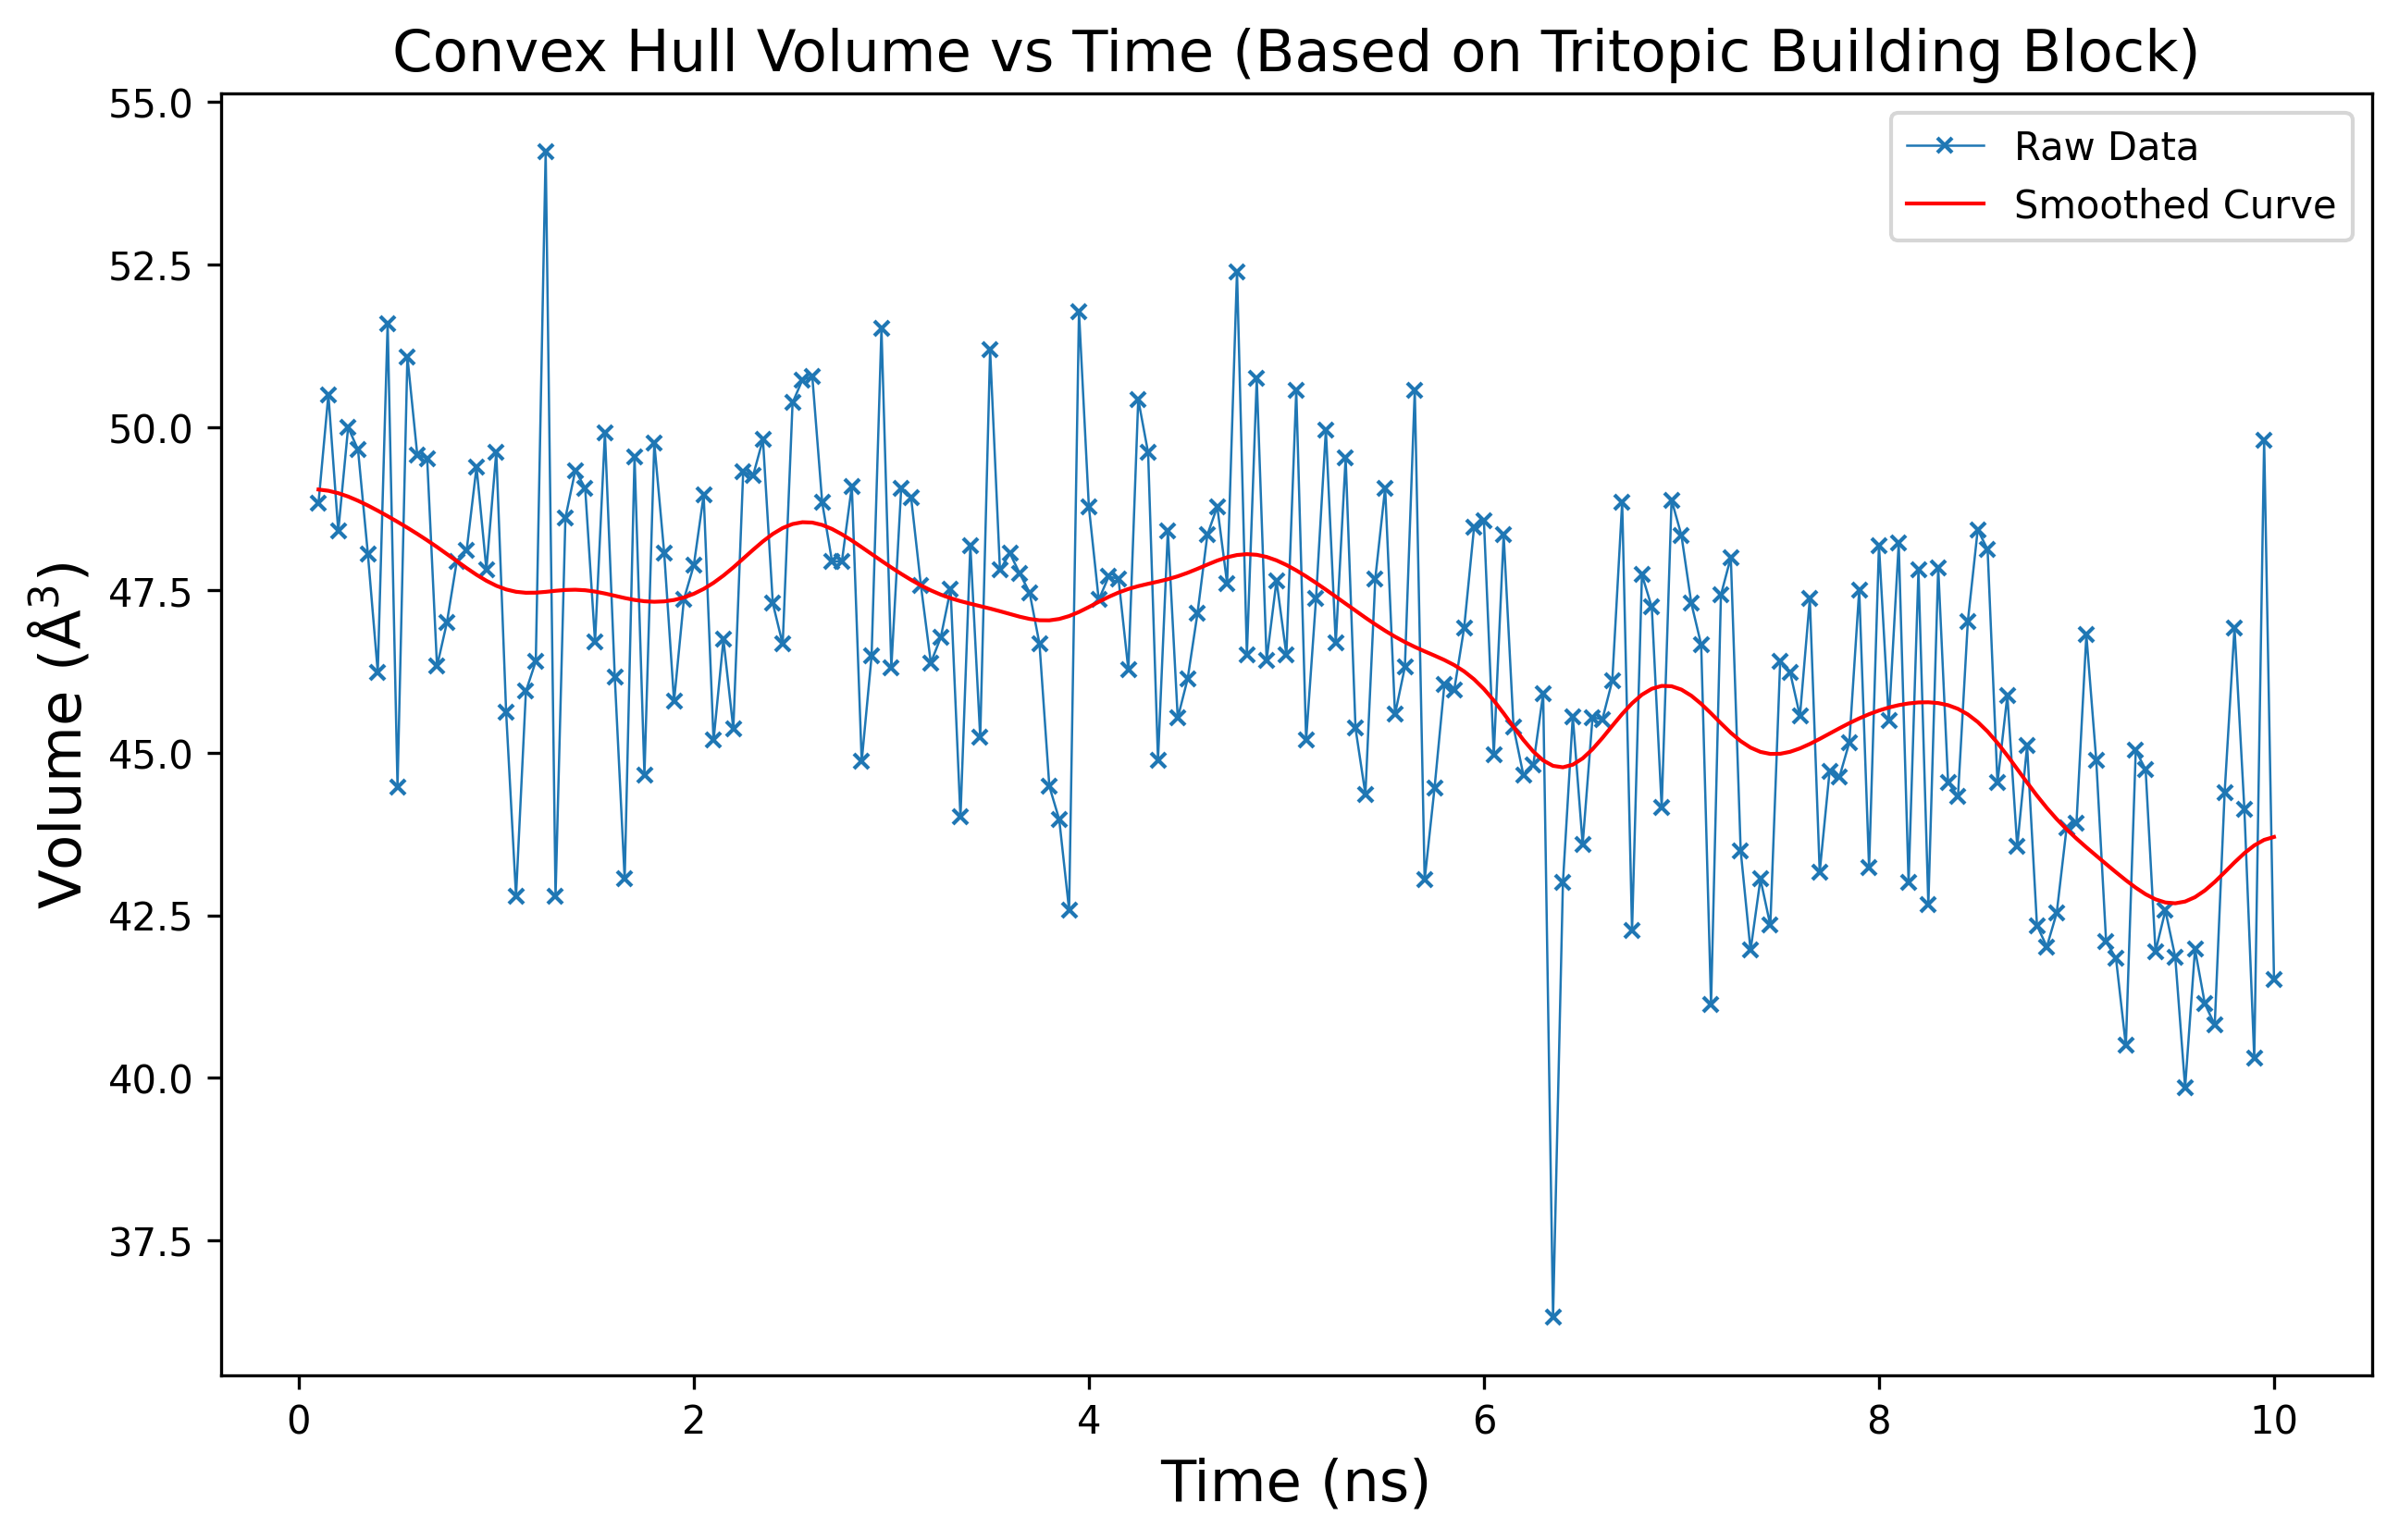

In [14]:
convex_hull_volume = convex_hull_volume(tritopic_bb_com_data, no_frames)

plt.figure(figsize=[10,6], dpi=300)
convex_hull_volume_smooth = gaussian_filter1d(convex_hull_volume[2:], sigma=5)  # increase sigma for more smoothing
plt.plot(time_data[2:], convex_hull_volume[2:], linestyle='-', marker='x',linewidth=0.6, markersize=4, label = 'Raw Data') # plot raw data
plt.plot(time_data[2:], convex_hull_volume_smooth, linewidth=1, color='red', label='Smoothed Curve') # plot gaussian smoothed curve
plt.title('Convex Hull Volume vs Time (Based on Tritopic Building Block)', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel("Volume ()", fontsize=15)
plt.ylabel(r'Volume (Å$^{3}$)',fontsize=15)
plt.legend()

In [15]:
# pywindow calculation types placeholder

#mol.calculate_centre_of_mass()
#mol.calculate_maximum_diameter()
#mol.calculate_average_diameter()
#mol.calculate_pore_diameter()
#mol.calculate_pore_volume()
#mol.calculate_pore_diameter_opt()
#mol.calculate_pore_volume_opt()
#mol.calculate_windows()
#mol.properties
#mol.full_analysis()